In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

from network.network import RNNModel
from utils import make_train_data, TrajectoryGenerator, create_ratemaps, plot_ratemaps
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [2]:
position, velocity, head_dir = torch.load('models/data.pt')
data = make_train_data(velocity.reshape(1, -1), head_dir.reshape(1, -1))

In [6]:
# load model
hidden_size = 256
mini_batch_size = 32
rnn_layer = 'custom'
rnn_model = torch.load(f'models/RNN-{hidden_size}-{rnn_layer}-model.pt')

rnn_model.eval()
aggregate_loss, y, x = rnn_model.evaluate(data, position)

# Only get the first entries because we only have a single trajectory to evaluate
y = y[0]
x = x[0]

Start evaluation run: 


Aggregated loss: 0.0008616971483232088  1.043 seconds for this run 



### Plot trajectories

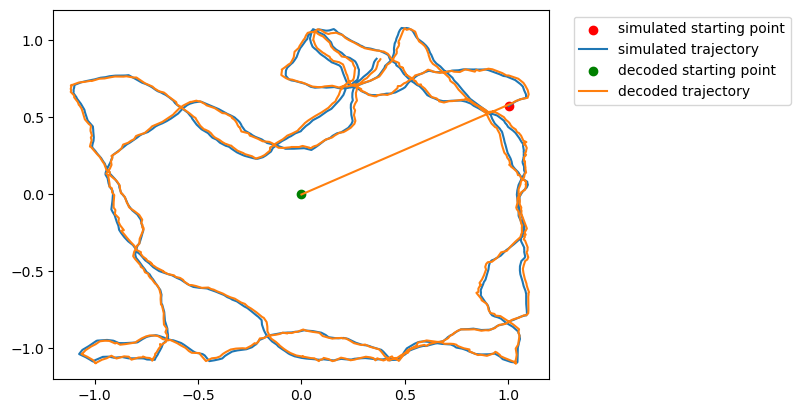

In [10]:
# plot trajectories generated from the network (on test data)
plt.scatter(position[0, 0], position[0, 1], color = 'red', label = 'simulated starting point')
plt.plot(position[:, 0], position[:, 1], label = 'simulated trajectory')

plt.scatter(y[ 0, 0], y[0, 1], color = 'green', label = 'decoded starting point')
plt.plot(y[:, 0], y[:, 1], label = 'decoded trajectory')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.legend(bbox_to_anchor=(1.5, 1.))

plt.savefig('trajectory.png', bbox_inches='tight')
# plt.show()

### Compute spatial maps

In [13]:
box_width = 2.2
box_height = 2.2
resolution = 0.2 # bin size in (m)

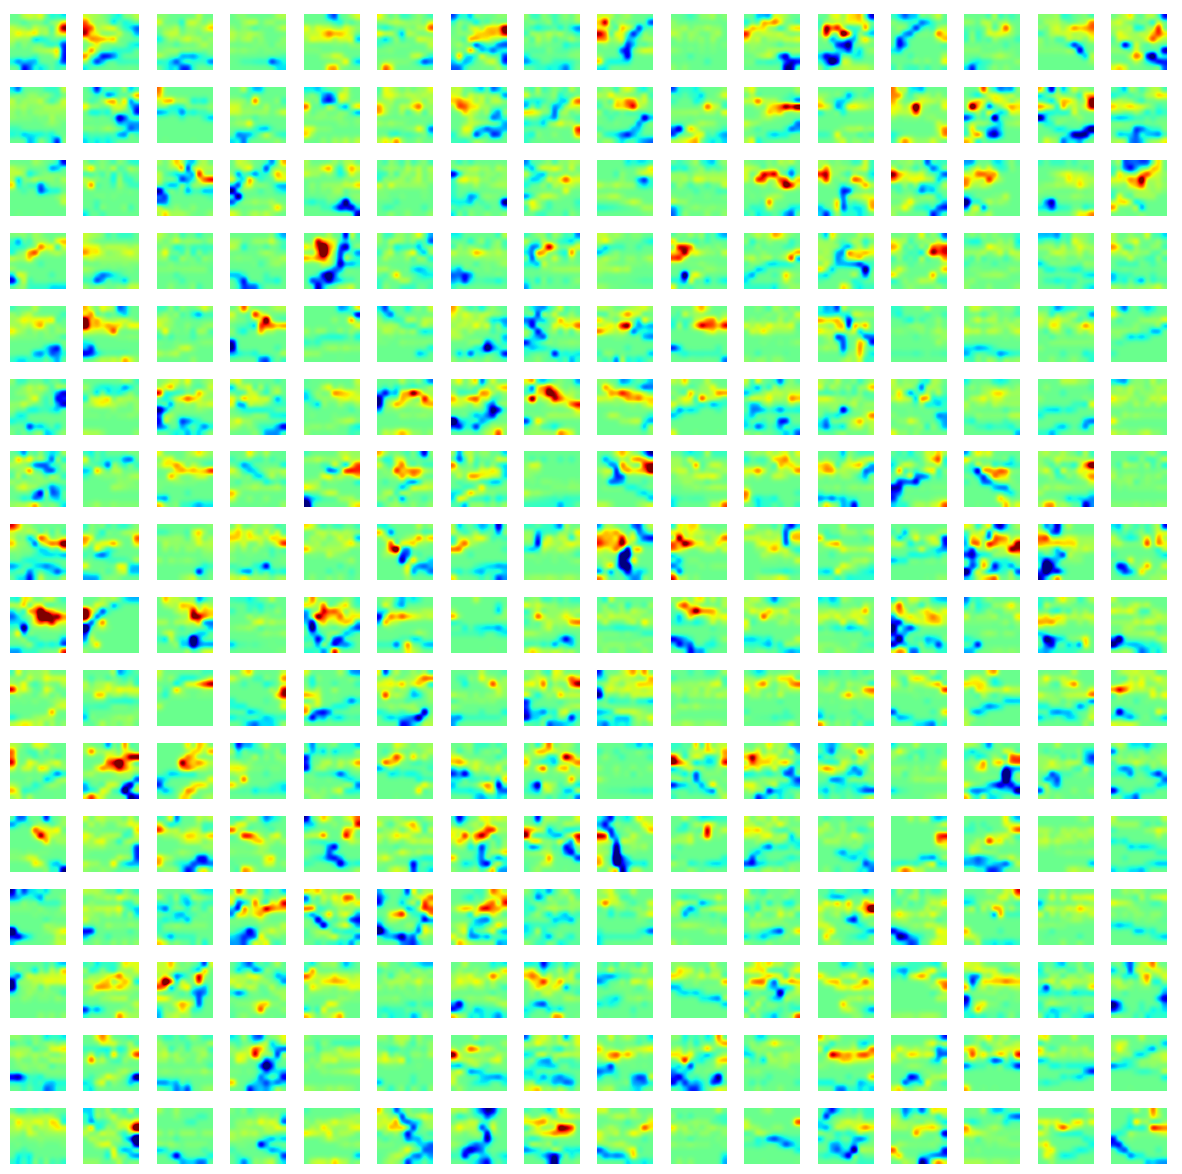

In [20]:
spatial_maps = create_ratemaps(x, y, box_width=box_width, box_height=box_height)
plot_ratemaps(spatial_maps, hidden_size, box_width, box_height, resolution, True)

In [12]:
# # get all combinations
# p = itertools.product(np.arange(0, np.sqrt(hidden_size), 1), np.arange(0, np.sqrt(hidden_size), 1))
# 
# fig, axs = plt.subplots(16, 16, figsize=(15, 15))
# for idx, comb in enumerate(p):
#     x_plt = spatial_maps[idx][:, 0]
#     y_plt = spatial_maps[idx][:, 1]
#     z_plt = spatial_maps[idx][:, 2]
#     
#     axs[int(comb[0]), int(comb[1])].scatter(x_plt, y_plt, c=z_plt, marker='.')
#     axs[int(comb[0]), int(comb[1])].set_xlim([-box_width / 2, box_width / 2])
#     axs[int(comb[0]), int(comb[1])].set_ylim([-box_width / 2, box_width / 2])
#     axs[int(comb[0]), int(comb[1])].set_xticks([])
#     axs[int(comb[0]), int(comb[1])].set_yticks([])
# plt.show()

In [31]:
# # heatmap of neuron 1
# x_plt = spatial_maps[0][:, 0]
# y_plt = spatial_maps[0][:, 1]
# z_plt = spatial_maps[0][:, 2]
# 
# x_bins = y_bins = np.arange(-box_width / 2, box_height / 2, resolution)  # 110 bins of size 2 cm
# 
# heatmap, xedges, yedges = np.histogram2d(x_plt, y_plt, bins=[x_bins, y_bins], weights=z_plt)
# plt.imshow(heatmap.T, extent=[x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()], origin='lower')
# plt.xticks([])
# plt.yticks([])
# plt.show()

In [14]:
# # scatter plot of neuron 1
# x_plt = spatial_maps[0][:, 0]
# y_plt = spatial_maps[0][:, 1]
# z_plt = spatial_maps[0][:, 2]
# 
# plt.scatter(x_plt, y_plt, c=z_plt, marker='.')
# plt.xlim([-box_width / 2, box_width / 2])
# plt.ylim([-box_width / 2, box_width / 2])
# plt.xticks([])
# plt.yticks([])
# plt.show()

### Sorscher's code snippet

In [11]:
def compute_ratemaps(model, trajectory_generator, options, res=20, n_avg=None, Ng=512, idxs=None):
    '''Compute spatial firing fields'''

    if not n_avg:
        n_avg = 1000 // options.sequence_length

    if not np.any(idxs):
        idxs = np.arange(Ng)
    idxs = idxs[:Ng]

    g = np.zeros([n_avg, options.batch_size * options.sequence_length, Ng])
    pos = np.zeros([n_avg, options.batch_size * options.sequence_length, 2])

    activations = np.zeros([Ng, res, res]) 
    counts  = np.zeros([res, res])

    for index in range(n_avg):
        inputs, pos_batch, _ = trajectory_generator.get_test_batch()
        g_batch = model.g(inputs).detach().cpu().numpy()
        
        pos_batch = np.reshape(pos_batch.cpu(), [-1, 2])
        g_batch = g_batch[:,:,idxs].reshape(-1, Ng)
        
        g[index] = g_batch
        pos[index] = pos_batch

        x_batch = (pos_batch[:,0] + options.box_width/2) / (options.box_width) * res
        y_batch = (pos_batch[:,1] + options.box_height/2) / (options.box_height) * res

        for i in range(options.batch_size*options.sequence_length):
            x = x_batch[i]
            y = y_batch[i]
            if x >=0 and x < res and y >=0 and y < res:
                counts[int(x), int(y)] += 1
                activations[:, int(x), int(y)] += g_batch[i, :]

    for x in range(res):
        for y in range(res):
            if counts[x, y] > 0:
                activations[:, x, y] /= counts[x, y]
                
    g = g.reshape([-1, Ng])
    pos = pos.reshape([-1, 2])

    # # scipy binned_statistic_2d is slightly slower
    # activations = scipy.stats.binned_statistic_2d(pos[:,0], pos[:,1], g.T, bins=res)[0]
    rate_map = activations.reshape(Ng, -1)

    return activations, rate_map, g, pos